# DELIVERABLE: FINE-TUNING AND ADAPTATION OF LANGUAGE MODELS

In this exercise the aim is to perform transfer learning from English to Spanish in the domain of sentiment analysis in opinions about movies.
It is recommended to use a cross-lingual model in order to facilitate the learning transfer.

- `xlm-roberta-base`
- `xlm-roberta-large`

Choose between transformers or simpletransformers

In [ ]:
!pip install transformers[torch]
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


Get the data of opinions about movies from IMDB dataset (parquet format)

In [ ]:
!wget -O imdb_train.parquet "https://huggingface.co/datasets/imdb/resolve/refs%2Fconvert%2Fparquet/plain_text/train/0000.parquet"
!wget -O imdb_test.parquet  "https://huggingface.co/datasets/imdb/resolve/refs%2Fconvert%2Fparquet/plain_text/test/0000.parquet"

--2023-11-15 15:29:33--  https://huggingface.co/datasets/imdb/resolve/refs%2Fconvert%2Fparquet/plain_text/train/0000.parquet
Resolving huggingface.co (huggingface.co)... 18.155.173.122, 18.155.173.45, 18.155.173.126, ...
Connecting to huggingface.co (huggingface.co)|18.155.173.122|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/imdb/d01f1e2b447fc7c7bffc1b03d64b5394e9fc9b1aac78a6548553f7c74bf69738?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%270000.parquet%3B+filename%3D%220000.parquet%22%3B&Expires=1700321373&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMDMyMTM3M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYXRhc2V0cy9pbWRiL2QwMWYxZTJiNDQ3ZmM3YzdiZmZjMWIwM2Q2NGI1Mzk0ZTlmYzliMWFhYzc4YTY1NDg1NTNmN2M3NGJmNjk3Mzg%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=nT%7EvXNhTfexumTvlwB2JE4VdqbHyaV-Re9bYOvOUcFkE7-0e3A7i1y6xRQjiqOfzM

In [ ]:
!ls

imdb_test.parquet  imdb_train.parquet  sample_data


# PART I: Training with the English dataset

## Loading, exploring and transforming data for tranformers

In [ ]:
import pandas as pd

df_train = pd.read_parquet("imdb_train.parquet")

In [ ]:
df_train.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
df_train['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

## Prepare the Trainer from a cross-lingual pretrained model

## Split train-validation-test

In [ ]:
from datasets import Dataset
train_df = df_train.sample(frac=0.9, random_state=200) #training dataset
valid_df = train_df.sample(frac=0.1, random_state=200) #validating dataset, which is validating that the model improves when is running.


#we transform the dataframes into Dataset
df_test = pd.read_parquet("imdb_test.parquet")
test_data = Dataset.from_pandas(df_test)
train_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(valid_df)

In [ ]:
print(train_df.shape, valid_df.shape)

(22500, 2) (2250, 2)


### Get the tokenizer and the classification model (from_pretrained)

In [ ]:
import torch
#use this device to move your PyTorch tensors and models to the appropriate hardware.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Specifying the model name, I chose 'xlm-roberta-base' instead of 'xlm-roberta-large' due to times of execution and problems with the gpu memory
model_name = 'xlm-roberta-base'

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = 2
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)#, max_length=512)

In [ ]:
#encoding the data with the tokenizer
test_token = test_data.map(tokenize, batched=True, batch_size=None)
valid_token = valid_data.map(tokenize, batched=True, batch_size=None)
train_token = train_data.map(tokenize, batched=True, batch_size=None)

data_encoded = {"train" : train_token, "validation" : valid_token, "test" : test_token}

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

In [ ]:
test_token.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

### Prepare the arguments of the trainer and set the trained object

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

#we define the metrics to evaluate or model
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [ ]:
import os
#setting the place to save the results of the model.
if not os.path.isdir("results"):
   os.mkdir("results")

In [ ]:
batch_size = 16 #we cannot put more batches due to limit of gpu memory

#Training arguments of the model
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2, #set 2 epochs due to really high times of execution with more epochs.
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps", #"epochs"
                                  fp16 = True, #speed optimization
                                  eval_steps = 50,
                                  #save_strategy="no",
                                  gradient_accumulation_steps=8, #Gradient accumulation is a technique where you can train on bigger batch sizes than your machine would normally be able to fit into memory
                                  disable_tqdm=False)

In [ ]:
#set the trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_encoded["train"],
    eval_dataset=data_encoded["validation"],
    compute_metrics=compute_metrics,
)

## Fine-tune the model

In [ ]:
#fine tuning the model
torch.cuda.empty_cache()
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.358024,0.872889,0.872159
100,No log,0.265128,0.904000,0.903802
150,No log,0.192592,0.929778,0.929771
200,No log,0.194824,0.940000,0.939974
250,No log,0.175186,0.942222,0.942216
300,No log,0.159070,0.947556,0.947549
350,No log,0.153242,0.947111,0.947109


TrainOutput(global_step=350, training_loss=0.25170030866350446, metrics={'train_runtime': 1762.4315, 'train_samples_per_second': 25.533, 'train_steps_per_second': 0.199, 'total_flos': 1.178421794746368e+16, 'train_loss': 0.25170030866350446, 'epoch': 1.99})

## Evaluate the model with the test dataset (English)

In [ ]:
#we show the evaluation in the training dataset
results = trainer.evaluate()
results

{'eval_loss': 0.15324167907238007,
 'eval_accuracy': 0.9471111111111111,
 'eval_f1': 0.9471093872484869,
 'eval_runtime': 27.1701,
 'eval_samples_per_second': 82.812,
 'eval_steps_per_second': 5.19,
 'epoch': 1.99}

In [ ]:
#we see the metrics in the test dataset
preds_output = trainer.predict(data_encoded["test"])
preds_output.metrics

{'test_loss': 0.17551685869693756,
 'test_accuracy': 0.93576,
 'test_f1': 0.9357517087837177,
 'test_runtime': 302.4681,
 'test_samples_per_second': 82.653,
 'test_steps_per_second': 5.167}

## Conclusions.

First we have to say that in this case I don't show the confusion matrix due to I did the Notebook in two sessions: one to the english part and one to the spanish. So, when I was doing the spanish part I accidentaly deleted the confusion matrix of this part and I can't execute the model another time due to lack of time. However, in the next cases the confusion matrix is showed.

Nevertheless, we can see in the metrics that the model has a very good accuracy (0.9357) for the test dataset. Maybe, if we have enough gpu ram, we could change some values such as the batch_size or the number of epochs to obtain even better results.


In [ ]:
#we save into google drive for executing the model in different sessions if we needed

#save in a local folder (not drive)
if not os.path.isdir("model"):
   os.mkdir("model")

model.save_pretrained('./model')
tokenizer.save_pretrained('./model')

#compressing the model
!tar -czf model_films_prova.tgz model/

In [ ]:
#acces to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copy to drive
!cp model_films_prova.tgz "/content/drive/MyDrive/UJI/Big Data/BigData NoteBooks/ model_film_prova_final"

# Part II: Adaptation to Spanish dataset (criticas_pelis)

Using the same model we have evaluated in the previous part, we are going to re-train it with the Spanish examples.

Take care of using the same labels in the Spanish dataset (0=negative, 1=positive). Neutral opinions (rate=3) will be discarded from the training dataset, but we can use them afterwards to predict their polarity with the resulting model.

## Load, explore and transform the Spanish dataset of Critics

In [ ]:
!wget https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
!gunzip criticas_pelis.csv.gz

--2023-11-15 15:31:35--  https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
Resolving krono.act.uji.es (krono.act.uji.es)... 150.128.97.37
Connecting to krono.act.uji.es (krono.act.uji.es)|150.128.97.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4447654 (4.2M) [application/x-gzip]
Saving to: ‘criticas_pelis.csv.gz’

criticas_pelis.csv. 100%[===================>]   4.24M  3.15MB/s    in 1.3s    

2023-11-15 15:31:37 (3.15 MB/s) - ‘criticas_pelis.csv.gz’ saved [4447654/4447654]



In [ ]:
#read and filter the data
df = pd.read_csv("criticas_pelis.csv", names=["Row", "File", "Text", "Rating"])
df.drop(columns = ["Row", "File"], inplace = True)
#we set to 0 the negative rates, 1 to the positive rates and 2 the neutral rates
def rating2label(x):
  if x < 3: return 0
  if x > 3: return 1
  return 2

#Modifying the columns
df['label'] = df['Rating'].apply(rating2label)

df.drop(columns=['Rating'], inplace=True)

df.rename(columns={"Text": "text"}, inplace = True)

In [ ]:
#Filtering Neutral opinions
df_esp = df.loc[df['label'] < 2]

In [ ]:
train_df = df_esp.sample(frac=0.9, random_state=200) #training dataset
valid_df = train_df.sample(frac=0.1, random_state=200) #validating dataset, which is validating that the model improves when is running.
test_df  = df_esp.drop(train_df.index)
train_df = train_df.drop(valid_df.index)

In [ ]:
print(train_df.shape, valid_df.shape, test_df.shape)

(2126, 2) (236, 2) (263, 2)


In [ ]:
#encoding the data
test_data_esp = Dataset.from_pandas(test_df)
train_data_esp = Dataset.from_pandas(train_df)
valid_data_esp = Dataset.from_pandas(valid_df)

test_token_esp = test_data_esp.map(tokenize, batched=True, batch_size=None)
valid_token_esp = valid_data_esp.map(tokenize, batched=True, batch_size=None)
train_token_esp = train_data_esp.map(tokenize, batched=True, batch_size=None)

data_encoded_esp = {"train" : train_token_esp, "validation" : valid_token_esp, "test" : test_token_esp}

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Map:   0%|          | 0/2126 [00:00<?, ? examples/s]

## Prepare the Trainer from the previous trained model

In [ ]:
#import the previous model of drive if we needed.
import shutil
#importing the model

# Define the path to the txt file in your Google Drive
google_drive_csv_path = "/content/drive/MyDrive/UJI/Big Data/BigData NoteBooks/ model_film_prova_final"

# Define the path to save the txt file locally in your Colab environment
local_csv_path = "/content/model_film_prova_final.tgz"

# Copy the CSV file from Google Drive to the local Colab environment
shutil.copy(google_drive_csv_path, local_csv_path)
#!gunzip model_films_prova.tgz
!tar -xvzf model_film_prova_final.tgz

model/
model/config.json
model/model.safetensors
model/tokenizer_config.json
model/special_tokens_map.json
model/tokenizer.json


In [ ]:
model_name_esp = 'model'

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_esp)

num_labels = 2
model_2 = (AutoModelForSequenceClassification.from_pretrained(model_name_esp, num_labels=num_labels).to(device))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

#we define the metrics to evaluate or model
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


batch_size = 16 #we cannot put more batches due to limit of gpu memory

#Training arguments of the model
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=10, #in this case we can put 10 epochs because the dataset is smaller.
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps", #"epochs"
                                  fp16 = True, #speed optimization
                                  eval_steps = 50,
                                  #save_strategy="no",
                                  gradient_accumulation_steps=8, #Gradient accumulation is a technique where you can train on bigger batch sizes than your machine would normally be able to fit into memory
                                  disable_tqdm=False)

trainer = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=data_encoded_esp["train"],  # Replace with your training dataset
    eval_dataset=data_encoded_esp["validation"],  # Replace with your validation dataset
    compute_metrics=compute_metrics,
)

## Fine-tune the model

In [ ]:
torch.cuda.empty_cache()
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.414977,0.877119,0.875856
100,No log,0.576774,0.881356,0.880245
150,No log,0.557140,0.902542,0.902016


TrainOutput(global_step=160, training_loss=0.10690687894821167, metrics={'train_runtime': 733.7947, 'train_samples_per_second': 28.973, 'train_steps_per_second': 0.218, 'total_flos': 5383778414776320.0, 'train_loss': 0.10690687894821167, 'epoch': 9.62})

## Evaluate the model with the test dataset (Spanish)

In [ ]:
preds_output = trainer.predict(data_encoded_esp["test"])
preds_output.metrics

{'test_loss': 0.4765837490558624,
 'test_accuracy': 0.9049429657794676,
 'test_f1': 0.9048191022071003,
 'test_runtime': 3.2936,
 'test_samples_per_second': 79.852,
 'test_steps_per_second': 5.162}

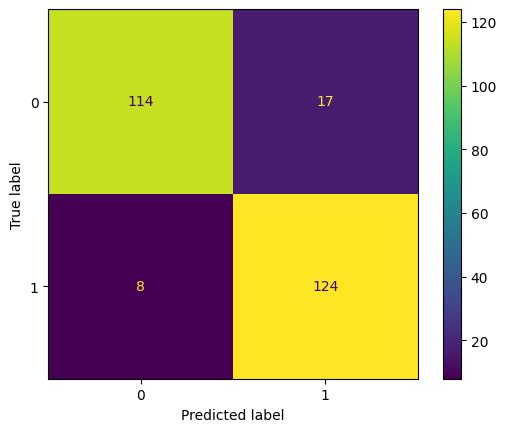

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_valid = np.array(data_encoded_esp["test"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = [0,1]


cm = confusion_matrix(y_valid, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


## Evaluate again the model on the English test dataset

In [ ]:
preds_output = trainer.predict(data_encoded["test"])
preds_output.metrics

{'test_loss': 0.4291999936103821,
 'test_accuracy': 0.924,
 'test_f1': 0.9239668514936998,
 'test_runtime': 299.5659,
 'test_samples_per_second': 83.454,
 'test_steps_per_second': 5.218}

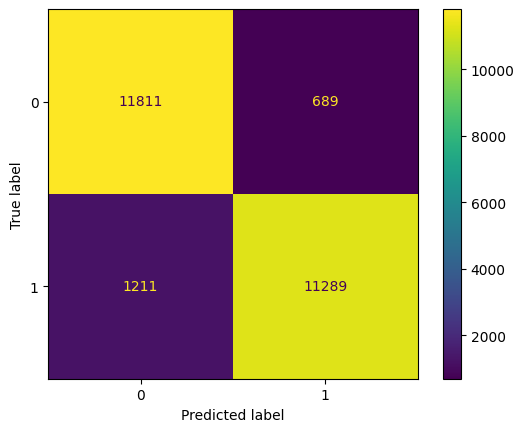

In [ ]:
y_valid = np.array(data_encoded["test"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = [0,1]


cm = confusion_matrix(y_valid, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

## Conclusions

Once the new model is trained, we obtain a prediction accuracy of approximately 0.905 for the Spanish test dataset. While for the English test dataset we obtain a prediction accuracy of 0.923. Thus, both predictions have a very high accuracy even with re-fitunning the model with the spanish dataset. Although if we go to the detail, for the English dataset we still get better results. This may be due to the fact that the first fine-tunning has been on the English dataset which is have a larger length so it could had a greater influence on the model. It is equally surprising how the model fits both data sets, obtaining such good prediction accuracy.


